# ABI Final Project

Importing libraries

In [2]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt


Importing csv file through which we can read data

In [3]:
rankings = pd.read_csv('fifa_ranking.csv')

print(rankings)


       rank country_full country_abrv  total_points  previous_points  \
0         1      Germany          GER           0.0               57   
1         2        Italy          ITA           0.0               57   
2         3  Switzerland          SUI           0.0               50   
3         4       Sweden          SWE           0.0               55   
4         5    Argentina          ARG           0.0               51   
...     ...          ...          ...           ...              ...   
57788   206     Anguilla          AIA           0.0                0   
57789   206      Bahamas          BAH           0.0                0   
57790   206      Eritrea          ERI           0.0                0   
57791   206      Somalia          SOM           0.0                0   
57792   206        Tonga          TGA           0.0                0   

       rank_change  cur_year_avg  cur_year_avg_weighted  last_year_avg  \
0                0           0.0                    0.0      

In [3]:
matches = pd.read_csv('results.csv')

print(matches)


             date    home_team   away_team  home_score  away_score  \
0      1872-11-30     Scotland     England           0           0   
1      1873-03-08      England    Scotland           4           2   
2      1874-03-07     Scotland     England           2           1   
3      1875-03-06      England    Scotland           2           2   
4      1876-03-04     Scotland     England           3           0   
...           ...          ...         ...         ...         ...   
39649  2018-06-27  Switzerland  Costa Rica           2           2   
39650  2018-06-28        Japan      Poland           0           1   
39651  2018-06-28      Senegal    Colombia           0           1   
39652  2018-06-28       Panama     Tunisia           1           2   
39653  2018-06-28      England     Belgium           0           1   

           tournament             city   country  neutral  
0            Friendly          Glasgow  Scotland    False  
1            Friendly           London 

In [4]:
world_cup = pd.read_csv('World Cup 2018 Dataset.csv')

print(world_cup)


            Team Group  Previous \nappearances  Previous \ntitles  \
0         Russia     A                    10.0                0.0   
1   Saudi Arabia     A                     4.0                0.0   
2          Egypt     A                     2.0                0.0   
3        Uruguay     A                    12.0                2.0   
4        Porugal     B                     6.0                0.0   
5          Spain     B                    14.0                1.0   
6        Morocco     B                     4.0                0.0   
7           IRAN     B                     4.0                0.0   
8         France     C                    14.0                1.0   
9      Australia     C                     4.0                0.0   
10          Peru     C                     4.0                0.0   
11       Denmark     C                     4.0                0.0   
12     Argentina     D                    16.0                2.0   
13       Iceland     D            

# Data Cleaning

In [5]:
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

rankings = rankings.replace({"IR Iran": "Iran"})

rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']

rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])


In [6]:
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})

matches['date'] = pd.to_datetime(matches['date'])



In [7]:
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

world_cup = world_cup.dropna(how='all')

world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})

world_cup = world_cup.set_index('Team')

world_cup.head(4)


,Group,First match \nagainst,Second match\n against,Third match\n against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia


In [8]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))


In [9]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']

matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2

matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']

matches['score_difference'] = matches['home_score'] - matches['away_score']

matches['is_won'] = matches['score_difference'] > 0 # take draw as lost

matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30

matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)


# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())

matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})

matches = matches.join(pd.get_dummies(matches['wc_participant']))


# Modeling

I used a simple Logistic regression, which yielded already rather good performance

In [10]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


I can see two main advantages of logistic regression over Chi2 or Fischer's exact test. The first is you can include more than one explanatory variable (dependent variable) and those can either be dichotomous, ordinal, or continuous. The second is that logistic regression provides a quantified value for the strength of the association adjusting for other variables (removes confounding effects). The exponential of coefficients correspond to odd ratios for the given factor.

In [11]:

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([('polynomial_features', features),('logistic_regression', logreg)])


model = model.fit(X_train, y_train)


/Users/krunal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


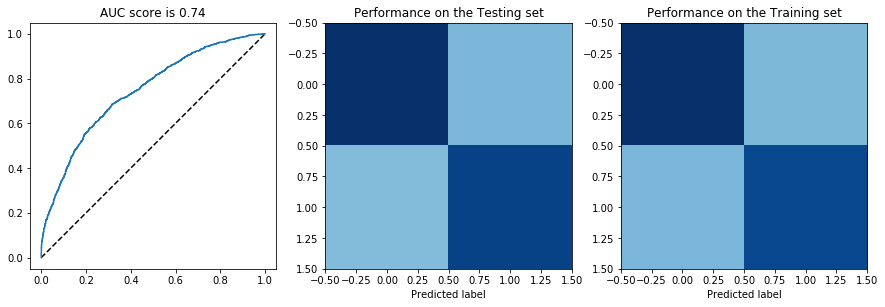

In [12]:
# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure(figsize=(15,5))

ax = plt.subplot(1,3,1)

ax.plot([0, 1], [0, 1], 'k--')

ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Testing set')


ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')


pass

# I consider this pretty good performance, minding that soccer matches have typically only few goals scored and therefore making their outcome even more unpredictable. Nevertheless, let's look at the bad predictions and see where we are making mistakes more often.

Stakes distribution in the wrong predictions
True     0.577872
False    0.422128
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


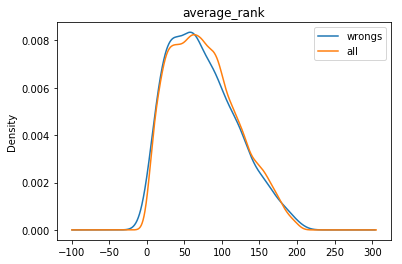

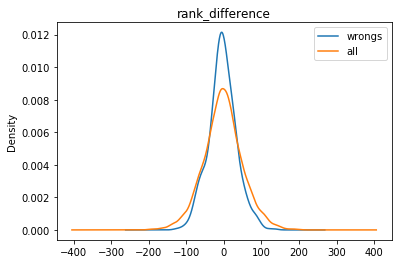

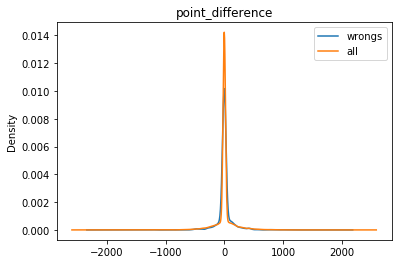

In [13]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    

print("Stakes distribution in the wrong predictions")

print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())

print("Stakes distribution overall")

print(X['is_stake'].value_counts() / X.shape[0])

From these figures, we read

we predict worse for closer ranks
lower ranks in general
and somewhat for matches with no stakes (Friendly here)
Luckily, this implies that for the world cup our predicitons may be somewhat even better

# World Cup simulation

# Group rounds

In [14]:
# let's define a small margin where we are safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]

world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [15]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.73
Belgium vs. Tunisia: Belgium wins with 0.61
Belgium vs. England: Belgium wins with 0.57
Panama vs. Tunisia: Tunisia wins with 0.73
Panama vs. England: England wins with 0.77
Tunisia vs. England: England wins with 0.57
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.67
Spain vs. Morocco: Spain wins with 0.65
Spain vs. Iran: Spain wins with 0.64
Morocco vs. Iran: Draw
___Starting group E:___
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.67
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.65
Costa Rica vs. Serbia: Draw
___Starting group H:___
Poland vs. Senegal: Poland wins with 0.60
Poland vs. Colombia: Draw
Poland vs. Japan: Poland wins with 0.73
Senegal vs. Colombia: Colombia wins with 0.59
Senegal vs. Japan: Senegal

# Single-elimination rounds

In [16]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




# Conclusion:
    
This method did not give the accurate result because we used points system to rank and classify the teams.
If teams were not classified based on rankinngs and previous results then we could have predicted with even more accuracy.
The

# References:
    
https://www.kaggle.com/alexkaechele/euros-2020-qualifier-predictions?scriptVersionId=15326883

https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner
